# Basic data analysis tasks

## Example: Fitness measured in Arabidopsis recombinant inbred lines

Topics: Reading data, JIT compiler, missing data, summary statistics, plots, linear regression 

In [1]:
using Statistics, CSV, Plots, DataFrames, GLM

In [2]:
agrenURL = "https://bitbucket.org/linen/smalldata/raw/3c9bcd603b67a16d02c5dc23e7e3e637758d4d5f/arabidopsis/agren2013.csv"
agren = CSV.read(download(agrenURL),missingstring="NA");

In [3]:
describe(agren)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Union…,Type
1,it09,12.2106,6.28846,12.0582,20.5921,,6,"Union{Missing, Float64}"
2,it10,8.08256,1.77401,7.53993,24.1761,,2,"Union{Missing, Float64}"
3,it11,8.92073,3.23889,8.52447,19.3107,,,Float64
4,sw09,10.8503,5.66443,10.832,15.0012,,6,"Union{Missing, Float64}"
5,sw10,23.3658,19.2318,23.0893,34.1327,,2,"Union{Missing, Float64}"
6,sw11,13.4934,4.47778,12.8102,32.1889,,,Float64
7,id,325.637,1,313.5,700,,,Int64
8,flc,1.535,1,2.0,2,,,Int64


In [4]:
mean(skipmissing(agren.it09))

12.210566789309647

In [5]:
mean.(skipmissing.(eachcol(agren)))

8-element Array{Float64,1}:
  12.210566789309647
   8.082563855927145
   8.920732948515003
  10.850313666266498
  23.36584553505025 
  13.493410758197498
 325.6375           
   1.535            

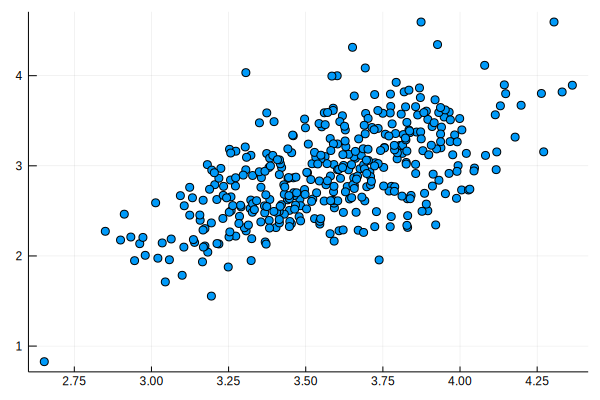

In [6]:
scatter(log2.(agren.it09),log2.(agren.it10),lab="")

In [7]:
out0 = lm(@formula(it11~it09+flc),agren)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

it11 ~ 1 + it09 + flc

Coefficients:
─────────────────────────────────────────────────────────────────────────────
              Estimate  Std. Error    t value  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)   1.32384    0.617786    2.14288     0.0327   0.109246   2.53844 
it09          0.644665   0.0408089  15.7972      <1e-43   0.564433   0.724897
flc          -0.191375   0.19962    -0.958696    0.3383  -0.583837   0.201088
─────────────────────────────────────────────────────────────────────────────

In [8]:
coef(out0)

3-element Array{Float64,1}:
  1.3238442023475048 
  0.6446651610115673 
 -0.19137472009472414

In [9]:
vcov(out0)

3×3 Array{Float64,2}:
  0.38166    -0.0215339    -0.0708066  
 -0.0215339   0.00166536    0.000779437
 -0.0708066   0.000779437   0.0398481  

In [10]:
out1 = glm(@formula(it11~it09),agren,Normal(),LogLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Normal{Float64},LogLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

it11 ~ 1 + it09

Coefficients:
───────────────────────────────────────────────────────────────────────────
              Estimate  Std. Error  z value  Pr(>|z|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  1.35933    0.056508    24.0556    <1e-99  1.24858    1.47009  
it09         0.0666698  0.00424176  15.7175    <1e-54  0.0583561  0.0749835
───────────────────────────────────────────────────────────────────────────

## Example: Bootstrapping

Topics: Random numbers, linear regression, indexing, distributed computing, multithreading

In [11]:
# Load random number package
using Random
# initialize random number generator
rng = MersenneTwister(1234321);
# set number of bootstrap sample
nboot = 10_000
# sample indices
idx = rand(rng,1:400,400,nboot);
# check size of index matrix
size(idx)

(400, 10000)

In [12]:
# allocate memory for bootstrap results
estBoot = zeros(nboot,3)
# loop over number of bootstrap samples; time
@time for i=1:nboot
    estBoot[i,:] = coef(lm(@formula(it11~it09+flc),agren[idx[:,i],:]))
end

  2.408745 seconds (4.16 M allocations: 1.106 GiB, 11.60% gc time)


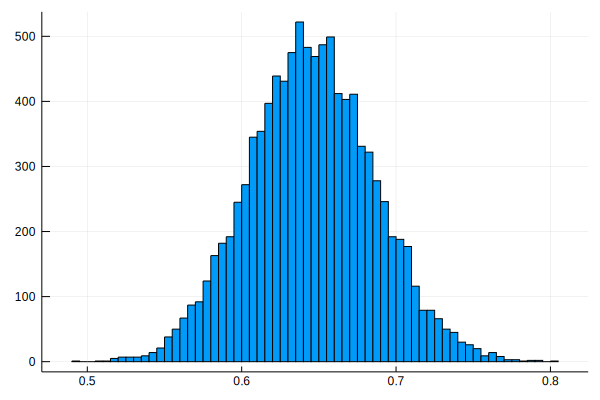

In [13]:
histogram(estBoot[:,2],lab="")

### Distributed computing

In [14]:
# load packages
using Distributed, SharedArrays
# add processes, but no more than 3 (one head, two workker)
if( nprocs()< 3 ) 
    addprocs(3-nprocs())
end

# load packages we are going to use on each process
@everywhere using Statistics, DataFrames, CSV, GLM, SharedArrays
# create array shared by all processes
estBootPar = SharedArray(zeros(nboot,3));
# send random index matrix to all processes
@everywhere idx = $idx
# send agren dataset to all processes
@everywhere agren = $agren

In [15]:
nprocs()

3

In [16]:
# bootstrap using distributed computing
@time @sync @distributed for i=1:nboot
    estBootPar[i,:] = coef(lm(@formula(it11~it09+flc),agren[idx[:,i],:]))
end

 18.318263 seconds (2.58 M allocations: 128.479 MiB, 0.39% gc time)


Task (done) @0x000000010cbecd90

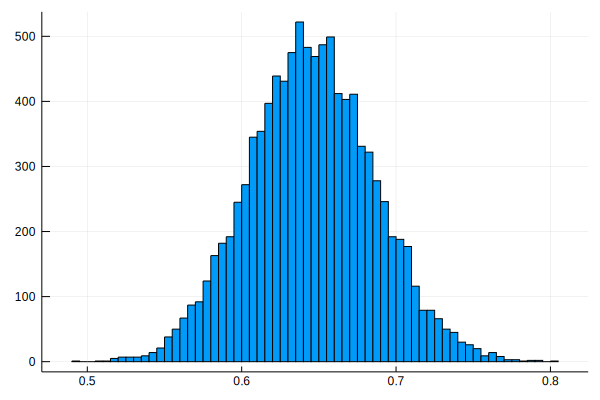

In [17]:
histogram(estBootPar[:,2],lab="")

### Multi-threading

To use multi-threading, one has to start Julia with multiple threads.  When using Jupyter, the easiest way to do this is to
install a kernel with the number of threads you will use.

    using IJulia
    installkernel("Julia (4 threads)", env=Dict("JULIA_NUM_THREADS"=>"4"))
    
If you want to change the number of threads on the fly.  Use

    ENV["JULIA_NUM_THREADS"] = 4
    using IJulia
    notebook()

In [18]:
# check number of threads
Threads.nthreads()
# initialize array with bootstrapped estimates
estBootThr = zeros(nboot,3);

The code to perform multithreading is almost identical to that for distributed processing, except for the macro that we invoke before the loop.

In [19]:
@time Threads.@threads for i=1:nboot
    estBootThr[i,:] = coef(lm(@formula(it11~it09+flc),agren[idx[:,i],:]))
end

  0.993669 seconds (3.09 M allocations: 1.005 GiB, 21.77% gc time)


## Example: Contructing the English Premier League points table

Topics: Data frames, data tabulation, functions, data wrangling

In [20]:
eplURL = "https://bitbucket.org/linen/smalldata/raw/47d88b298b2b1cb18d900e13aea8de8ec14de311/soccer/E0.csv"
epl = CSV.read(download(eplURL))

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG
,String,String,String,String,Int64,Int64,String,Int64,Int64
1,E0,08/08/15,Bournemouth,Aston Villa,0,1,A,0,0
2,E0,08/08/15,Chelsea,Swansea,2,2,D,2,1
3,E0,08/08/15,Everton,Watford,2,2,D,0,1
4,E0,08/08/15,Leicester,Sunderland,4,2,H,3,0
5,E0,08/08/15,Man United,Tottenham,1,0,H,1,0
6,E0,08/08/15,Norwich,Crystal Palace,1,3,A,0,1
7,E0,09/08/15,Arsenal,West Ham,0,2,A,0,1
8,E0,09/08/15,Newcastle,Southampton,2,2,D,1,1
9,E0,09/08/15,Stoke,Liverpool,0,1,A,0,0


In [21]:
using Statistics, StatsBase

function homeresult(x)
    if(x=="A") return "L"
        elseif(x=="H") return "W"
            else return "D"
    end
end
        
function awayresult(x)
    if(x=="H") return "L"
        elseif(x=="A") return "W"
            else return "D"
    end
end
                  
homeResults = by(epl,:HomeTeam,x -> DataFrame(countmap(homeresult.(x.FTR))))
sort!(homeResults,:HomeTeam)
awayResults = by(epl,:AwayTeam,x -> DataFrame(countmap(awayresult.(x.FTR))))
sort!(awayResults,:AwayTeam)
                
results = DataFrame(hcat(awayResults.AwayTeam,hcat(awayResults[:,2:4] .+ homeResults[:,2:4])))          
results.points = results.W*3 + results.D 
DataFrames.names!(results,[:Team,:D,:L,:W,:Points])

,Team,D,L,W,Points
,String,Int64,Int64,Int64,Int64
1,Arsenal,11,7,20,71
2,Aston Villa,8,27,3,17
3,Bournemouth,9,18,11,42
4,Chelsea,14,12,12,50
5,Crystal Palace,9,18,11,42
6,Everton,14,13,11,47
7,Leicester,12,3,23,81
8,Liverpool,12,10,16,60
9,Man City,9,10,19,66


In [22]:
sort!(results,:Points,rev=true)

,Team,D,L,W,Points
,String,Int64,Int64,Int64,Int64
1,Leicester,12,3,23,81
2,Arsenal,11,7,20,71
3,Tottenham,13,6,19,70
4,Man City,9,10,19,66
5,Man United,9,10,19,66
6,Southampton,9,11,18,63
7,West Ham,14,8,16,62
8,Liverpool,12,10,16,60
9,Stoke,9,15,14,51
